In [10]:
%matplotlib inline

import datetime
# import goks.xgb
import keras
# import keras.utils
import matplotlib
import matplotlib.pyplot as pt
import numpy as np
import pandas as pd
import seaborn as sb
# import scipy.optimize
import sklearn
import sklearn.cross_validation
import sklearn.manifold
import sklearn.metrics
# import sklearn.ensemble
# import sklearn.neighbors
# import xgboost

In [11]:
class MyHistory( keras.callbacks.Callback ):
    def __init__( self, m ):
        self.m = m
    def on_train_begin( self, logs={} ):
        self.weights = []
        self.bias = []
#         self.updates = []
#         self.total_loss = []
    def on_epoch_end( self, epoch, logs={} ):
        ws = []
        bs = []
        for layer in self.m.layers:
            ws = np.append( ws, layer.get_weights()[ 0 ] )
            bs = np.append( bs, layer.get_weights()[ 1 ] )
        self.weights.append( ws )
        self.bias.append( bs )
#         self.updates.append( self.m.model.train_function.updated[ 2 ] )
#         self.total_loss.append( self.m.model.train_function.updated[ 0 ] )

# Load data

In [12]:
rdf = pd.read_csv( './data/winequality-red.csv', sep=';' )
# rdf[ 'wine' ] = 1
rdf.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [13]:
wdf = pd.read_csv( './data/winequality-white.csv', sep=';' )
# wdf[ 'wine' ] = 2
wdf.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [14]:
df = rdf.append( wdf )
# df = wdf
# df.loc[ df.quality < 8, 'quality' ] = 0
# df.loc[ df.quality >= 8, 'quality' ] = 1
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


[3 4 5 6 7 8 9]


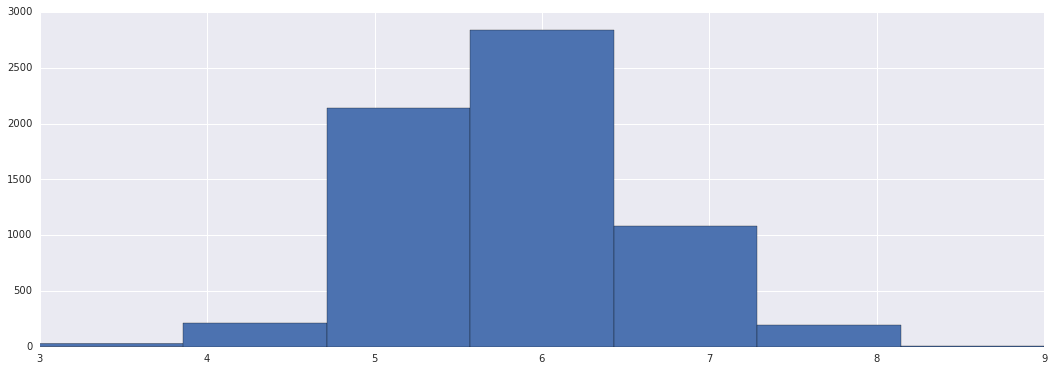

In [15]:
print np.sort( df.quality.unique() )
df.quality.hist( bins=len( df.quality.unique() ), figsize=( 18, 6 ) )

# Train normal multiclass network
The expected result is that the network would constantly outputs the class priors

In [16]:
train_x = df.drop( 'quality', axis=1 ).values
train_y = df.quality.values
print train_x.shape, train_y.shape

(6497, 11) (6497,)


In [17]:
nn_train_x = ( ( train_x - train_x.mean() ) / train_x.var() )
nn_train_y = np.array( [ train_y == i for i in np.sort( np.unique( train_y ) ) ] ).astype( int ).T
# nn_train_y = train_y
print nn_train_x.shape, nn_train_y.shape

(6497, 11) (6497, 7)


In [18]:
m = keras.models.Sequential()
m.add( keras.layers.Dense( 512, input_dim=nn_train_x.shape[ 1 ], init='glorot_normal', activation='relu' ) )
m.add( keras.layers.Dense( 512, init='glorot_normal', activation='relu' ) )
m.add( keras.layers.Dropout( .5 ) )
m.add( keras.layers.Dense( 7, init='glorot_normal', activation='softmax' ) )
# m.add( keras.layers.Dense( 1, init='glorot_normal', activation='softmax' ) )
m.compile( loss='categorical_crossentropy', optimizer='adam' )
# m.compile( loss='binary_crossentropy', optimizer='adam' )

# h2 = MyHistory( m )
h = m.fit( nn_train_x, nn_train_y, batch_size=1000, nb_epoch=1000, verbose=0 )#, callbacks=[ h2 ] )
print 'loss: %r' % m.evaluate( nn_train_x, nn_train_y, verbose=0 )
p = m.predict( nn_train_x )

loss: 1.0724245472487917


In [19]:
q = np.argmax( p, axis=1 ) + train_y.min()

In [20]:
# pd.DataFrame( h2.weights ).diff().plot.line( legend=False, figsize=( 18, 6 ) )

In [21]:
# pd.DataFrame( h2.bias ).diff().plot.line( legend=False, figsize=( 18, 6 ) )

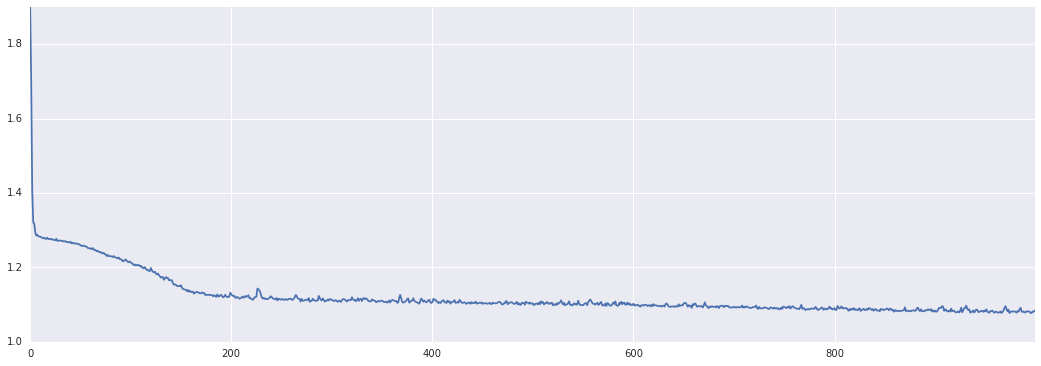

In [22]:
pd.DataFrame( h.history[ 'loss' ] ).plot.line( legend=False, figsize=( 18, 6 ) )
# for h in hs:
# #     pd.DataFrame( h.history[ 'loss' ] ).plot.line( legend=False, figsize=( 18, 6 ) )
#     pt.plot( h.history[ 'loss' ] )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc188688050>]], dtype=object)

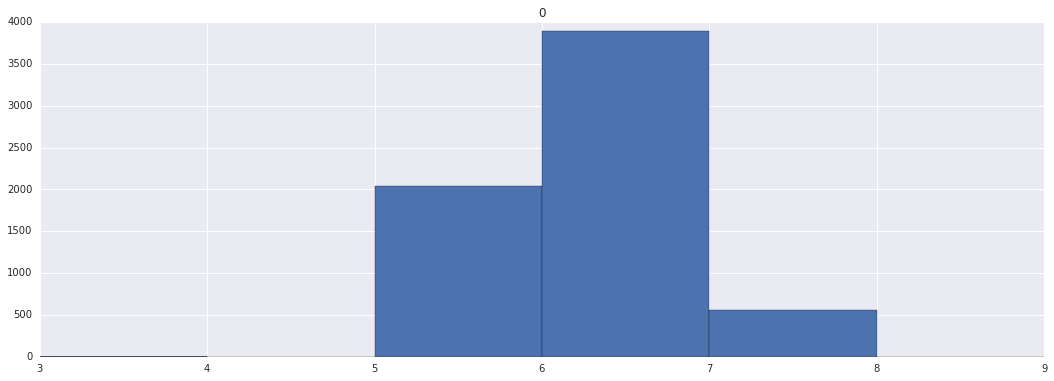

In [24]:
pd.DataFrame( q ).hist( bins=np.sort( np.unique( train_y ) ), figsize=( 18, 6 ) )

In [25]:
print sklearn.metrics.classification_report( train_y, q, digits=4 )

             precision    recall  f1-score   support

          3     0.4000    0.0667    0.1143        30
          4     0.0000    0.0000    0.0000       216
          5     0.5698    0.5440    0.5566      2138
          6     0.5113    0.7020    0.5917      2836
          7     0.4704    0.2428    0.3203      1079
          8     0.0000    0.0000    0.0000       193
          9     0.0000    0.0000    0.0000         5

avg / total     0.4907    0.5261    0.4952      6497



/usr/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
print sklearn.metrics.confusion_matrix( train_y, q )

[[   2    0   13   15    0    0    0]
 [   2    0  115   97    2    0    0]
 [   1    0 1163  957   17    0    0]
 [   0    0  652 1991  193    0    0]
 [   0    0   81  736  262    0    0]
 [   0    0   17   95   81    0    0]
 [   0    0    0    3    2    0    0]]


# Train normal two-class network

In [27]:
data_x = df.drop( 'quality', axis=1 ).values
data_y = df.quality.apply( lambda x: 1 if x >= 8 else 0 ).values
print data_x.shape, data_y.shape
# cv = sklearn.cross_validation.StratifiedKFold( data_y, 3 )
# print cv

(6497, 11) (6497,)


In [28]:
train_x, train_y = data_x, data_y
test_x, test_y = data_x, data_y
nn_train_x, nn_train_y = ( ( train_x - train_x.mean() ) / train_x.var() ), np.array( [ train_y == i for i in np.sort( np.unique( train_y ) ) ] ).astype( int ).T
nn_test_x, nn_test_y = ( ( test_x - test_x.mean() ) / test_x.var() ), test_y

m = keras.models.Sequential()
m.add( keras.layers.Dense( 256, input_dim=nn_train_x.shape[ 1 ], init='glorot_normal', activation='relu' ) )
# m.add( keras.layers.Dense( 256, init='glorot_normal', activation='relu' ) )
m.add( keras.layers.Dense( 2, init='glorot_normal', activation='softmax' ) )
# m.compile( loss='binary_crossentropy', optimizer='adam' )
m.compile( loss='categorical_crossentropy', optimizer='adam' )

h = m.fit( nn_train_x, nn_train_y, batch_size=1000, nb_epoch=1000, verbose=0 )
print 'train loss: %r' % m.evaluate( nn_train_x, nn_train_y, verbose=0 )
# print 'test loss:  %r' % m.evaluate( nn_test_x, nn_test_y, verbose=0 )
# train_ps.append( m.predict( nn_train_x ) )
# test_ps.append( m.predict( nn_test_x ) )

train loss: 0.12063229129713775


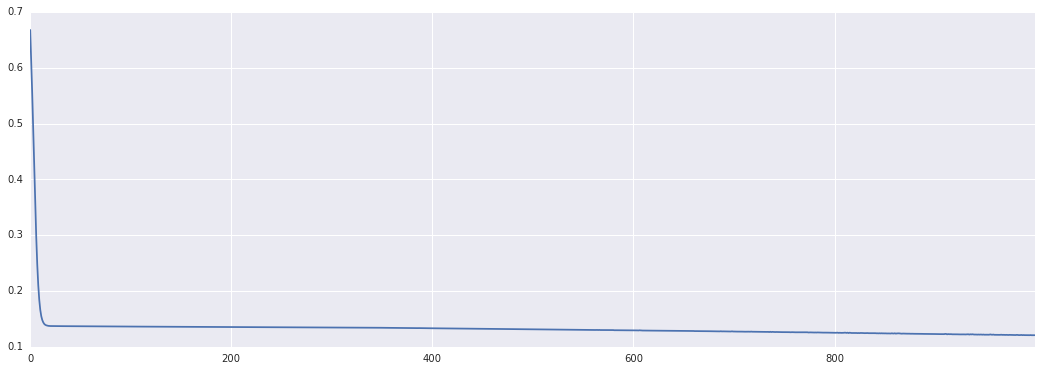

In [29]:
pd.DataFrame( h.history[ 'loss' ] ).plot.line( legend=False, figsize=( 18, 6 ) )

In [30]:
print sklearn.metrics.classification_report( train_y, np.argmax( m.predict( nn_train_x ), axis=1 ) )

             precision    recall  f1-score   support

          0       0.97      1.00      0.98      6299
          1       0.00      0.00      0.00       198

avg / total       0.94      0.97      0.95      6497



In [31]:
print sklearn.metrics.confusion_matrix( train_y, np.argmax( m.predict( nn_train_x ), axis=1 ) )

[[6299    0]
 [ 198    0]]


# SVM-SMOTE

In [32]:
import unbalanced_dataset
import unbalanced_dataset.over_sampling
smote = unbalanced_dataset.over_sampling.SMOTE( kind='svm' )
smote_x, smote_y = smote.fit_transform( data_x, data_y )
print smote_x.shape, smote_y.shape

Determining classes statistics... 2 classes detected: Counter({0: 6299, 1: 198})
Finding the 10 nearest neighbours...
done!
Out of 130 support vectors, 63 are noisy, 125 are in danger and 5 are safe.
Finding the 5 nearest neighbours...
done!
Creating synthetic samples...Generated 3233 new samples ...
Generated 2868 new samples ...
done!
(12598, 11) (12598,)


(array([ 6299.,  6299.]),
 array([ 0. ,  0.5,  1. ]),
 <a list of 2 Patch objects>)

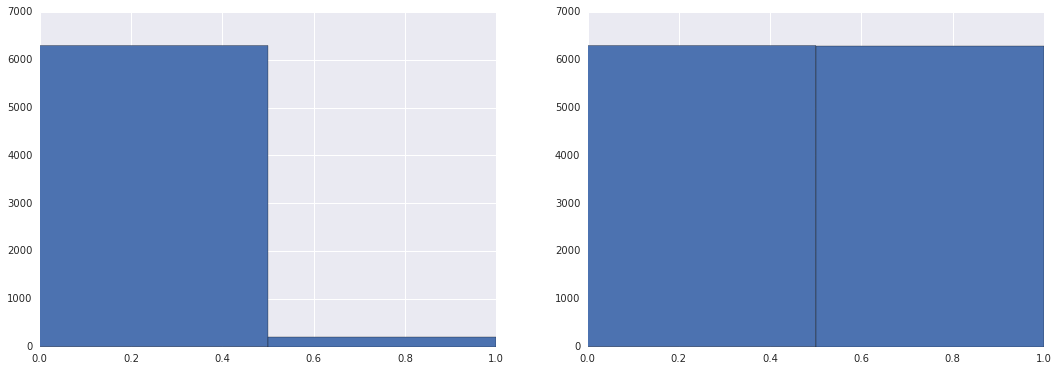

In [33]:
fig, axs = pt.subplots( 1, 2, sharex=True, figsize=( 18, 6 ) )
axs[ 0 ].hist( data_y, bins=2 )
axs[ 1 ].hist( smote_y, bins=2 )

In [34]:
pca = sklearn.decomposition.PCA( 2 )
data2 = pca.fit_transform( data_x )

In [35]:
pca = sklearn.decomposition.PCA( 2 )
smote2 = pca.fit_transform( smote_x )

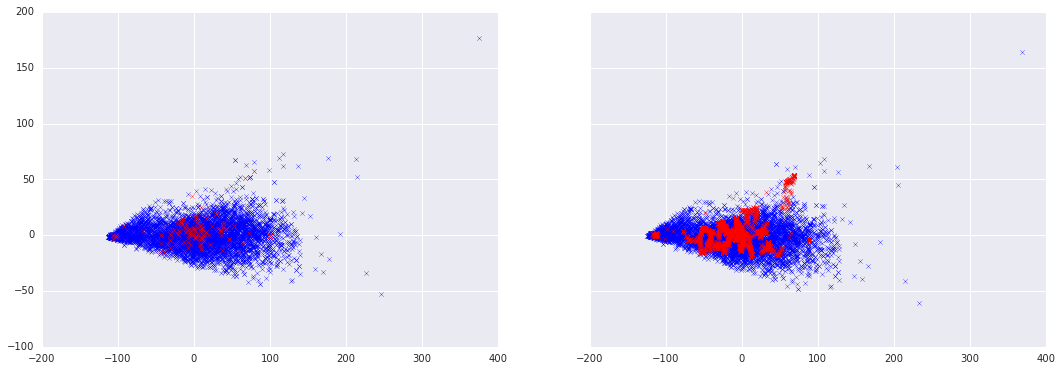

In [36]:
# pt.figure( figsize=( 18, 6 ) )
fig, axs = pt.subplots( 1, 2, sharey=True, figsize=( 18, 6 ) )
axs[ 0 ].scatter( data2[ data_y == 0 ].T[ 0 ], data2[ data_y == 0 ].T[ 1 ], c='b', marker='x' )
axs[ 0 ].scatter( data2[ data_y == 1 ].T[ 0 ], data2[ data_y == 1 ].T[ 1 ], c='r', marker='x' )
axs[ 1 ].scatter( smote2[ smote_y == 0 ].T[ 0 ], smote2[ smote_y == 0 ].T[ 1 ], c='b', marker='x' )
axs[ 1 ].scatter( smote2[ smote_y == 1 ].T[ 0 ], smote2[ smote_y == 1 ].T[ 1 ], c='r', marker='x' )

In [37]:
# smotedf = pd.DataFrame( smote_x )
# datadf = pd.DataFrame( data_x )[ data_y == 1 ].drop_duplicates()
# print smotedf.shape, datadf.shape
# # datadf[ data_y == 1 ]
# # smotedf[ smotedf[ 0 ] == datadf[ data_y == 1 ][ 0 ] ]
# # smotedf[ 0 ]
# datadf = datadf.reset_index()
# datadf.columns = [ 'x', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ]
# tdf = smotedf.merge( datadf, how='left' )
# tdf[ pd.notnull( tdf.x ) ].x.unique()

In [38]:
train_x, train_y = smote_x, smote_y
test_x, test_y = smote_x, smote_y
nn_train_x, nn_train_y = ( ( train_x - train_x.mean() ) / train_x.var() ), np.array( [ train_y == i for i in np.sort( np.unique( train_y ) ) ] ).astype( int ).T
nn_test_x, nn_test_y = ( ( test_x - train_x.mean() ) / train_x.var() ), np.array( [ test_y == i for i in np.sort( np.unique( test_y ) ) ] ).astype( int ).T

In [39]:
m = keras.models.Sequential()
m.add( keras.layers.Dense( 512, input_dim=nn_train_x.shape[ 1 ], init='glorot_normal', activation='relu' ) )
m.add( keras.layers.Dense( 512, init='glorot_normal', activation='relu' ) )
m.add( keras.layers.Dropout( .5 ) )
m.add( keras.layers.Dense( 2, init='glorot_normal', activation='softmax' ) )
m.compile( loss='categorical_crossentropy', optimizer='adam' )

h = m.fit( nn_train_x, nn_train_y, batch_size=1000, nb_epoch=5000, verbose=0 )
print 'train loss: %r' % m.evaluate( nn_train_x, nn_train_y, verbose=0 )
# print 'test loss:  %r' % m.evaluate( nn_test_x, nn_test_y, verbose=0 )
# train_ps.append( m.predict( nn_train_x ) )
# test_ps.append( m.predict( nn_test_x ) )

train loss: 0.084703608383597861


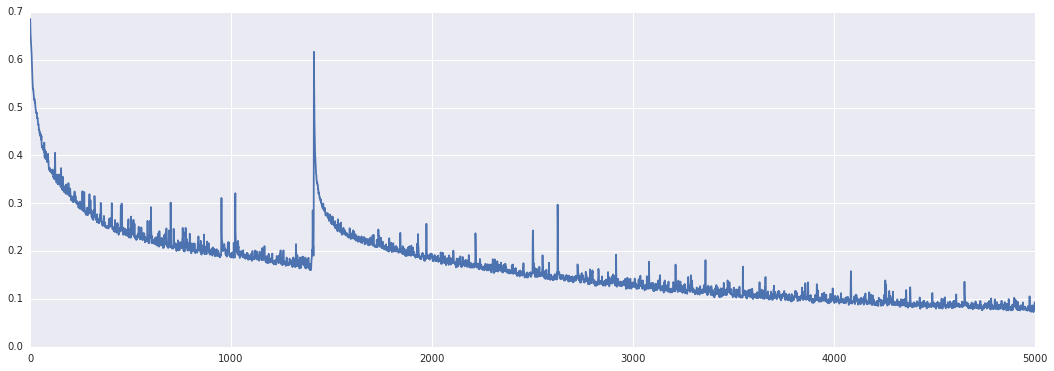

In [40]:
pd.DataFrame( h.history[ 'loss' ] ).plot.line( legend=False, figsize=( 18, 6 ) )

In [41]:
print sklearn.metrics.classification_report( train_y, np.argmax( m.predict( nn_train_x ), axis=1 ) )

             precision    recall  f1-score   support

          0       0.98      0.96      0.97      6299
          1       0.96      0.98      0.97      6299

avg / total       0.97      0.97      0.97     12598



In [42]:
print sklearn.metrics.confusion_matrix( train_y, np.argmax( m.predict( nn_train_x ), axis=1 ) )

[[6053  246]
 [ 155 6144]]


In [43]:
print sklearn.metrics.confusion_matrix( data_y, np.argmax( m.predict( ( data_x - train_x.mean() ) / train_x.var() ), axis=1 ) )

[[6053  246]
 [  32  166]]


In [44]:
t = smote.svm_.support_[ data_y[ smote.svm_.support_ ] == 1 ]
print sklearn.metrics.confusion_matrix( data_y[ t ], np.argmax( m.predict( ( data_x[ t ] - train_x.mean() ) / train_x.var() ), axis=1 ) )

[[  0   0]
 [ 32 161]]


In [45]:
print sklearn.metrics.confusion_matrix( data_y[ t ][ smote.noise_bool ], np.argmax( m.predict( ( data_x[ t ][ smote.noise_bool ] - train_x.mean() ) / train_x.var() ), axis=1 ) )

[[ 0  0]
 [27 36]]


In [46]:
print sklearn.metrics.confusion_matrix( data_y[ t ][ ~smote.noise_bool ][ smote.danger_bool ], np.argmax( m.predict( ( data_x[ t ][ ~smote.noise_bool ][ smote.danger_bool ] - train_x.mean() ) / train_x.var() ), axis=1 ) )

[[  0   0]
 [  5 120]]


In [47]:
print sklearn.metrics.confusion_matrix( data_y[ t ][ ~smote.noise_bool ][ smote.safety_bool ], np.argmax( m.predict( ( data_x[ t ][ ~smote.noise_bool ][ smote.safety_bool ] - train_x.mean() ) / train_x.var() ), axis=1 ) )

[[5]]


In [48]:
print len( smote.noise_bool )
print 'noise: %r' % smote.noise_bool.sum()
print 'danger: %r' % smote.danger_bool.sum()
print 'safe: %r' % smote.safety_bool.sum()

193
noise: 63
danger: 125
safe: 5


# Approachs for imbalanced dataset
- sampling techniques
    - monte carlo sampling
    - synthetic minority over sampling technique (SMOTE)
- cost sensitive learning
    - classifier evaluation
    - minimizing expected cost
    - instance reweighting
    - class probability threshold
- one class learning
- bagging techniques
    - balance cascade
    - easy ensemble